# ANÁLISE EXPLORATÓRIA BRASILEIRÃO

In [135]:
import os
import numpy
import pandas
from matplotlib import pyplot
from scipy import stats as scipy_stats
from statsmodels import stats as statsmodels_stats

%matplotlib inline

In [136]:
csv_filename = 'campeonato-brasileiro-full.csv'

In [137]:
# import pandas
working_dir = os.getcwd()
root_folder = os.path.dirname(working_dir)
datasets_folder = os.path.join(root_folder, 'datasets')
brasileirao_folder = os.path.join(datasets_folder, 'brasileirao')
csv_path = os.path.join(brasileirao_folder, csv_filename)
csv_path

'c:\\Dropbox\\DS\\python\\infnet\\infsports\\datasets\\brasileirao\\campeonato-brasileiro-full.csv'

In [138]:
raw = pandas.read_csv(csv_path, sep=',', decimal='.')
print(raw.columns)
df = raw[["ID", "mandante", "visitante", "vencedor", "arena", "mandante_Placar", "visitante_Placar"]].copy()

df["mandante"] = df["mandante"].str.strip().str.lower()
df["visitante"] = df["visitante"].str.strip().str.lower()
df["vencedor"] = df["vencedor"].str.strip().str.lower()
df["arena"] = df["arena"].str.strip().str.lower()
df = df.set_index("ID")

df

Index(['ID', 'rodata', 'data', 'hora', 'mandante', 'visitante',
       'formacao_mandante', 'formacao_visitante', 'tecnico_mandante',
       'tecnico_visitante', 'vencedor', 'arena', 'mandante_Placar',
       'visitante_Placar', 'mandante_Estado', 'visitante_Estado'],
      dtype='object')


,mandante,visitante,vencedor,arena,mandante_Placar,visitante_Placar
ID,,,,,,
1,guarani,vasco,guarani,brinco de ouro,4,2
2,athletico-pr,gremio,athletico-pr,arena da baixada,2,0
3,flamengo,coritiba,-,maracanã,1,1
4,goias,paysandu,-,serra dourada,2,2
5,internacional,ponte preta,-,beira rio,1,1
...,...,...,...,...,...,...
8021,cuiaba,coritiba,cuiaba,arena pantanal,2,1
8022,bragantino,fluminense,fluminense,nabizão,0,1
8023,corinthians,atletico-mg,atletico-mg,neo química arena,0,1


# ANÁLISE EXPLORATÓRIA

### Probabilidade do {meu_time} pontuar

In [139]:
# filtrar jogos do flamengo
meu_time = 'flamengo'
p_intervalo_de_confianca = 0.99

In [140]:
jogos_meu_time_mandante = df['mandante'] == meu_time
jogos_meu_time_visitante = df['visitante'] == meu_time

df_jogos_meu_time = df[jogos_meu_time_mandante | jogos_meu_time_visitante].copy()

vitorias = df_jogos_meu_time['vencedor'] == meu_time
empates = df_jogos_meu_time['vencedor'] == '-'
df_jogos_meu_time['pontuou'] = (vitorias | empates).astype(int)

In [141]:
pdf_meu_time_pontuou = df_jogos_meu_time[['pontuou']].value_counts(normalize=True).sort_index()

pdf_meu_time_pontuou

pontuou
0          0.298718
1          0.701282
Name: proportion, dtype: float64

In [142]:
q_intervalo = 1.0 - (1.0 - p_intervalo_de_confianca)/2.0
proportion_z = scipy_stats.norm.ppf(q_intervalo)
p_meu_time = pdf_meu_time_pontuou[1]
n_jogos_meu_time = len(df_jogos_meu_time)
error_bar = proportion_z*numpy.sqrt(p_meu_time * (1.0 - p_meu_time) / len(df_jogos_meu_time))

q_intervalo, proportion_z, p_meu_time, n_jogos_meu_time, error_bar

(0.995, 2.5758293035489004, 0.7012820512820512, 780, 0.04221305651786535)

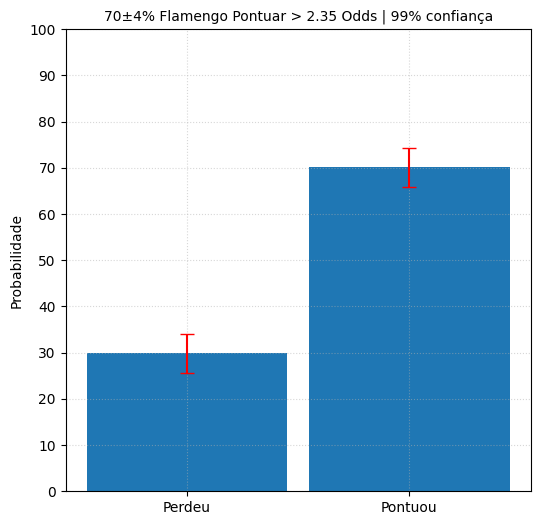

In [143]:
p_vitoria_meu_time = pdf_meu_time_pontuou[1]

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
_ = ax.set_title(f'{100.0*p_vitoria_meu_time:.0f}\u00b1{100.0*error_bar:.0f}% {meu_time.capitalize()} Pontuar > {p_vitoria_meu_time/(1.0-p_vitoria_meu_time):.2f} Odds | {100.0*p_intervalo_de_confianca:.0f}% confiança', fontsize=10)
_ = ax.set_ylabel('Probabilidade')
_ = ax.set_yticks(numpy.arange(0, 110, 10))
_ = ax.bar([ x[0] for x in pdf_meu_time_pontuou.index], 100.0*pdf_meu_time_pontuou.values, width=0.9, tick_label=[ 'Perdeu', 'Pontuou'])
_ = ax.errorbar([ x[0] for x in pdf_meu_time_pontuou.index], 100.0*pdf_meu_time_pontuou.values, yerr=100.0*error_bar, fmt='none', ecolor='red', capsize=5)
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_ylim([0, 100.0])

### Probabilidade de Jogo em Estádio

In [144]:
minha_arena = 'maracanã'
p_intervalo_de_confianca = 0.99
some_games = 1.0

q_intervalo = 1.0 - (1.0 - p_intervalo_de_confianca)/2.0
proportion_z = scipy_stats.norm.ppf(q_intervalo)
n_jogos = len(df)

pdf_arena = df[['arena']].value_counts(normalize=True)
more_than_some_games = pdf_arena.values > some_games/len(pdf_arena)
p_others = pdf_arena[~more_than_some_games].sum()
pdf_arena = pdf_arena[more_than_some_games]
pdf_arena['outros'] = p_others
pdf_arena = pdf_arena.sort_values(ascending=False)

In [145]:
df_arena = pdf_arena.to_frame()
df_arena['error_bar'] = 0.0
error_bars = []

for arena in df_arena.index:
    p_arena = df_arena.loc[arena, 'proportion']
    df_arena.loc[arena, 'error_bar'] = proportion_z*numpy.sqrt(p_arena * (1.0 - p_arena) / n_jogos)

df_arena = df_arena.sort_values(by='proportion', ascending=True)

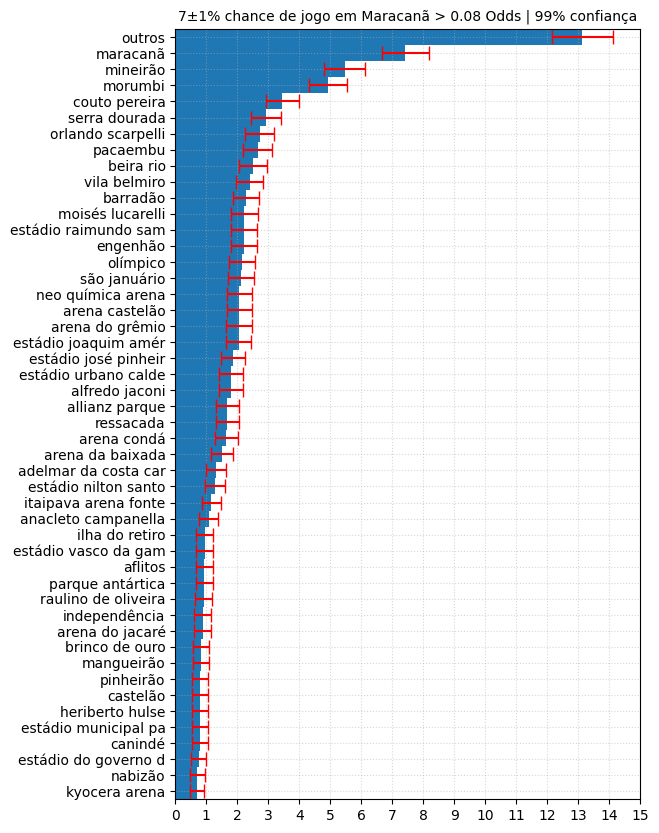

In [146]:
p_minha_arena = df_arena.loc[minha_arena]['proportion'].values[0]
error_minha_arena = df_arena.loc[minha_arena]['error_bar'].values[0]

fig = pyplot.figure(figsize=(6, 10))
ax = fig.add_subplot(111)
_ = ax.set_title(f"{100.0*p_minha_arena:.0f}\u00b1{100.0*error_minha_arena:.0f}% chance de jogo em {minha_arena.capitalize()} > {p_minha_arena/(1.0-p_minha_arena):.2f} Odds | {100.0*p_intervalo_de_confianca:.0f}% confiança", fontsize=10)
_ = ax.barh(numpy.arange(len(df_arena)), 100.0*df_arena['proportion'].values, tick_label=[x[0][:20] for x in df_arena.index.values],height=1.0)
_ = ax.errorbar(100.0*df_arena.proportion.values, numpy.arange(len(pdf_arena)), xerr=100.0*df_arena.error_bar.values, fmt='none', ecolor='red', capsize=5)
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_ylim([-0.5, len(df_arena)-0.5])
_ = ax.set_xticks(numpy.arange(0, 16, 1))

### Distribuição Massa de Gols Brasileirão

In [147]:
meu_numero_de_gols = 4

df_gols = df[["mandante_Placar", "visitante_Placar", "vencedor"]].copy()
df_gols["total"] = df_gols["mandante_Placar"] + df_gols["visitante_Placar"]
df_gols = df_gols.total.value_counts(normalize=True).sort_index().to_frame()
df_gols['cdf'] = df_gols.proportion.cumsum()
df_gols

,proportion,cdf
total,,
0,0.079875,0.079875
1,0.202991,0.282866
2,0.243364,0.526231
3,0.215327,0.741558
4,0.136075,0.877632
5,0.070779,0.948411
6,0.031028,0.979439
7,0.014704,0.994143
8,0.004361,0.998505


In [148]:
p_menos_que_meus_gols = df_gols.loc[meu_numero_de_gols]['cdf']

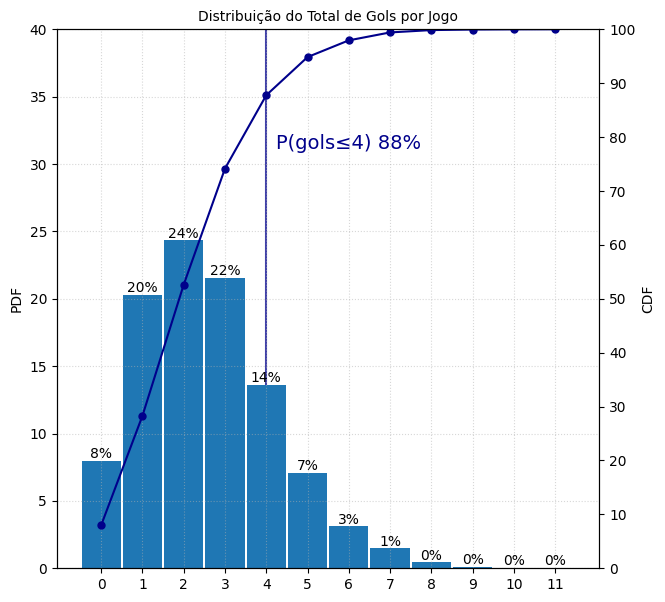

In [149]:
fig = pyplot.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
_ = ax.plot([meu_numero_de_gols, meu_numero_de_gols], [0, 100.0], color='darkblue', zorder=-1, alpha=0.75)
_ = ax.set_title('Distribuição do Total de Gols por Jogo', fontsize=10)
_ = ax.bar(df_gols.index, 100.0*df_gols.proportion.values, tick_label=df_gols.index, width=0.95)
_ = ax.set_ylabel('PDF')
_ = ax.set_ylim([0, 40.0])
_ = ax.grid(ls=':', alpha=0.5)
for gol_amount, p_gol in df_gols.iterrows():
    _ = ax.annotate(f'{100.0*p_gol.proportion:.0f}%', xy=(gol_amount, 100.0*p_gol.proportion), xytext=(gol_amount, 100.0*p_gol.proportion+0.2), ha='center', fontsize=10)
# plot cdf
ax2 = ax.twinx()
_ = ax2.plot(df_gols.index, 100.0*df_gols.cdf.values, color='darkblue', marker='o', ms=5)
_ = ax2.set_ylim([0, 100.0])
_ = ax2.set_ylabel('CDF')
_ = ax2.set_yticks(numpy.arange(0, 110, 10))
# annotate meu gols
_ = ax2.annotate(f'P(gols\u2264{meu_numero_de_gols}) {100.0*p_menos_que_meus_gols:.0f}%', xy=(meu_numero_de_gols, 100.0*p_menos_que_meus_gols), xytext=(meu_numero_de_gols+2, 100.0*p_menos_que_meus_gols-10), ha='center', fontsize=14, color='darkblue')

### DISTRIBUIÇÃO DA POSIÇÃO NO CAMPO

In [150]:
manning_path = os.path.join(datasets_folder,'manning', 'manning.csv')
df_manning = pandas.read_csv(manning_path, sep=';', decimal=',')

In [151]:
meu_campo = 30

p_menor_que_meu_campo = (df_manning['field'] <= meu_campo).sum()/len(df_manning)

p_menor_que_meu_campo

0.1808695652173913

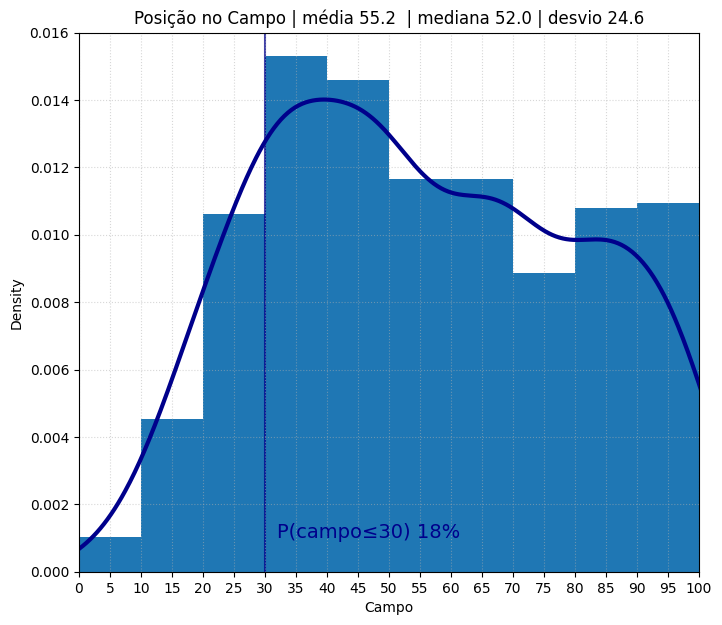

In [152]:
fig = pyplot.figure(figsize=(8, 7))
ax = fig.add_subplot(111)

_ = df_manning.field.hist(bins=numpy.arange(0, 110, 10), ax=ax, density=True)
_ = df_manning.field.plot.kde(ax=ax, color='darkblue', linewidth=3, alpha=1.0)
_ = ax.set_title(f"Posição no Campo | média {df_manning.field.mean():.1f}  | mediana {df_manning.field.median():.1f} | desvio {df_manning.field.std():.1f}", fontsize=12)
_ = ax.set_xlabel('Campo')
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_xlim([0, 100])
_ = ax.set_ylim([0, 0.016])
_ = ax.set_xticks(numpy.arange(0, 105, 5))
_ = ax.plot([meu_campo, meu_campo], [0, 100.0], color='darkblue', zorder=1, alpha=0.75)
# annotate meu campo
_ = ax.annotate(f'P(campo\u2264{meu_campo}) {100.0*p_menor_que_meu_campo:.0f}%', xy=(meu_campo, 0.0), xytext=(meu_campo + 2, 0.001), ha='left', fontsize=14, color='darkblue')

### Chutes por Time

In [153]:
# IMPORT CHUTES
chutes_path = os.path.join(datasets_folder,'brasileirao', 'campeonato-brasileiro-estatisticas-full.csv')
df_chutes = pandas.read_csv(chutes_path, sep=',', decimal='.')
df_chutes = df_chutes.loc[df_chutes.chutes > 0.0, ["chutes"]] # EXCLUSÃO DE PERFORMANCES PIFIAS

s, loc, scale = scipy_stats.lognorm.fit(df_chutes.chutes, floc=0)
print(s, loc, scale)

0.42260915475990607 0 11.820392466940401


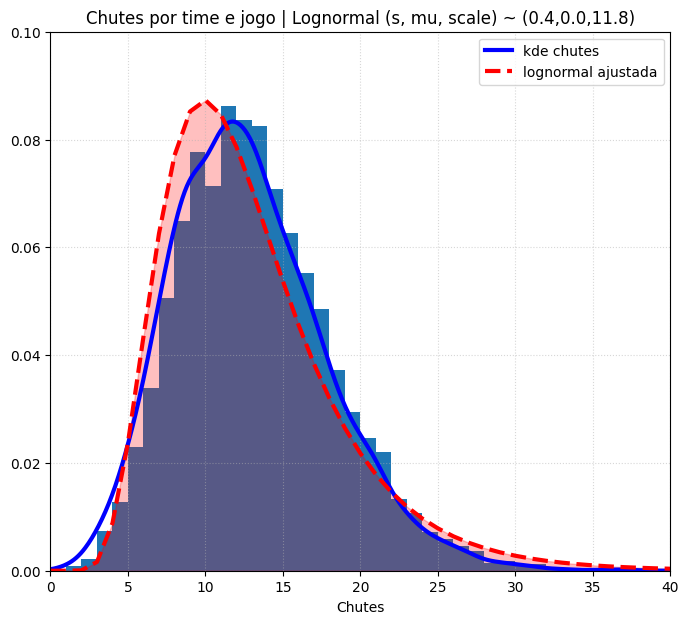

In [154]:
fig = pyplot.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
df_chutes.chutes.hist(ax=ax, bins=numpy.arange(0, 41, 1), density=True)
df_chutes.chutes.plot.kde(ax=ax, linewidth=3, label = "kde chutes", color='blue')
_ = ax.plot(numpy.arange(0, 41, 1), scipy_stats.lognorm.pdf(numpy.arange(0, 41, 1), s, loc, scale), color='red', linewidth=3, alpha=1.0, ls='--', label='lognormal ajustada')
_ = ax.fill_between(numpy.arange(0, 41, 1), scipy_stats.lognorm.pdf(numpy.arange(0, 41, 1), s, loc, scale), color='red', alpha=0.25)
_ = ax.set_title(f"Chutes por time e jogo | Lognormal (s, mu, scale) ~ ({s:.1f},{loc:.1f},{scale:.1f})", fontsize=12)
_ = ax.set_xlabel('Chutes')
_ = ax.set_ylabel('')
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_xlim([0, 40])
_ = ax.set_ylim([0, 0.1])
_ = ax.set_xticks(numpy.arange(0, 41, 5))
_ = ax.legend()
# anotatte some lognormal region


In [155]:
def pdf_time_pontuou(time : str, df_jogos : pandas.DataFrame) -> pandas.Series:
    jogos_time_mandante = df_jogos['mandante'] == time
    jogos_time_visitante = df_jogos['visitante'] == time

    df_jogos_time = df[jogos_time_mandante | jogos_time_visitante].copy()

    vitorias = df_jogos_time['vencedor'] == time
    empates = df_jogos_time['vencedor'] == '-'
    df_jogos_time['pontuou'] = (vitorias | empates).astype(int)
    return df_jogos_time[['pontuou']].value_counts(normalize=True).sort_index(), len(df_jogos_time)

In [168]:
from statsmodels.stats.proportion import proportions_ztest, test_proportions_2indep
time_A = 'flamengo'
time_B = 'vasco'
p_base = 0.65
a_significancia = 0.01
p_intervalo_de_confianca = 0.99

pdf_time_A, n_time_A = pdf_time_pontuou(time_A, df)
p_time_A = pdf_time_A[1]
q_intervalo_A = 1.0 - (1.0 - p_intervalo_de_confianca)/2.0
proportion_z_A = scipy_stats.norm.ppf(q_intervalo_A)
error_bar_A = proportion_z_A*numpy.sqrt(p_time_A * (1.0 - p_time_A) / n_time_A)

pdf_time_B, n_time_B = pdf_time_pontuou(time_B, df)
p_time_B = pdf_time_B[1]
q_intervalo_B = 1.0 - (1.0 - p_intervalo_de_confianca)/2.0
proportion_z_B = scipy_stats.norm.ppf(q_intervalo_B)
error_bar_B = proportion_z_B*numpy.sqrt(p_time_B * (1.0 - p_time_B) / n_time_B)

z_score_uni, p_value_uni = proportions_ztest(p_time_A*n_time_A, n_time_A, p_base)
H_a = a_significancia >= p_value_uni

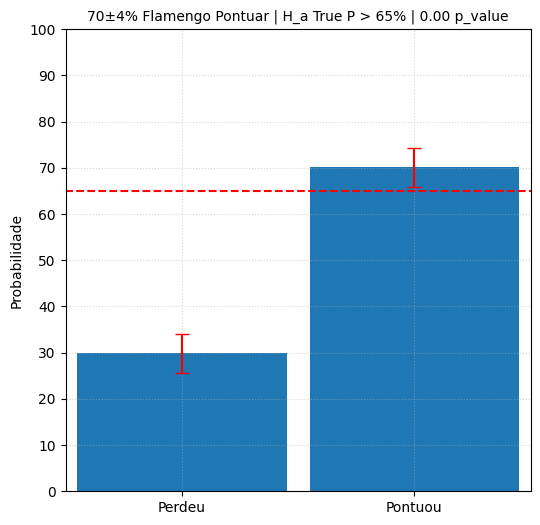

In [169]:
p_time_A = pdf_time_A[1]

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
_ = ax.set_title(f'{100.0*p_time_A:.0f}\u00b1{100.0*error_bar_A:.0f}% {time_A.capitalize()} Pontuar | H_a {H_a} P > {100.0*p_base:.0f}% | {p_value_uni:.2f} p_value', fontsize=10)
_ = ax.set_ylabel('Probabilidade')
_ = ax.set_yticks(numpy.arange(0, 110, 10))
_ = ax.bar([ x[0] for x in pdf_time_A.index], 100.0*pdf_time_A.values, width=0.9, tick_label=[ 'Perdeu', 'Pontuou'])
_ = ax.errorbar([ x[0] for x in pdf_time_A.index], 100.0*pdf_time_A.values, yerr=100.0*error_bar, fmt='none', ecolor='red', capsize=5)
_ = ax.plot([-1, 2], [100.0*p_base, 100.0*p_base], color='red', ls='--')
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_xlim([-0.5, 1.5])
_ = ax.set_ylim([0, 100.0])

In [170]:
# two test between time A and B
z_comparison, p_value_comparison = test_proportions_2indep(p_time_A*n_time_A, n_time_A, p_time_B*n_time_B, n_time_B, alternative="larger")
z_comparison, p_value_comparison


(2.683949487937864, 0.0036379049009766704)

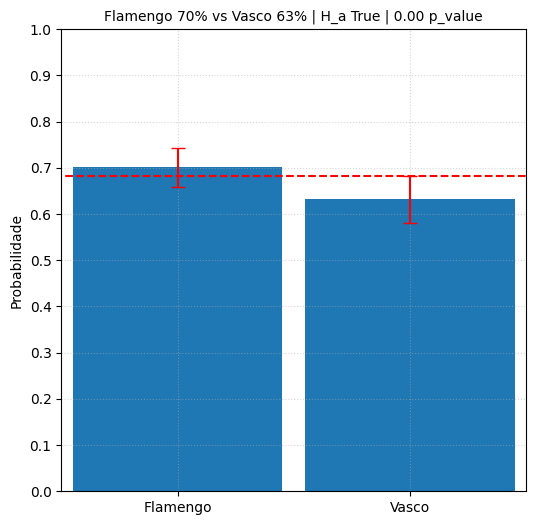

In [171]:
# plot comparison between A and B
fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
_ = ax.set_title(f"{time_A.capitalize()} {100.0*p_time_A:.0f}% vs {time_B.capitalize()} {100.0*p_time_B:.0f}% | H_a {H_a} | {p_value_comparison:.2f} p_value", fontsize=10)
_ = ax.bar([0, 1], [p_time_A, p_time_B], width=0.9, tick_label=[time_A.capitalize(), time_B.capitalize()])
_ = ax.errorbar([0, 1], [p_time_A, p_time_B], yerr=[error_bar_A, error_bar_B], fmt='none', ecolor='red', capsize=5)
_ = ax.grid(ls=':', alpha=0.5)
_ = ax.set_ylim([0, 1.0])
_ = ax.set_ylabel('Probabilidade')
_ = ax.set_yticks(numpy.arange(0, 1.1, 0.1))
_ = ax.plot([-1, 2], [p_time_B + error_bar_B, p_time_B + error_bar_B], color='red', ls='--')
_ = ax.set_xlim([-0.5, 1.5])

In [172]:
arena_counts = df.arena.value_counts().values
chi, pvalue = scipy_stats.chisquare(arena_counts)
chi, pvalue

(22388.317757009347, 0.0)

In [173]:
limiar_de_gols = 1
a_significancia = 0.01

df_A_mandante_gols = df.loc[df.mandante == time_A, 'mandante_Placar'].copy()
pdf_A_mandante_gols = df_A_mandante_gols.value_counts(normalize=True).sort_index().to_frame()

df_B_mandante_gols = df.loc[df.mandante == time_B, 'mandante_Placar'].copy()
pdf_B_mandante_gols = df_B_mandante_gols.value_counts(normalize=True).sort_index().to_frame()

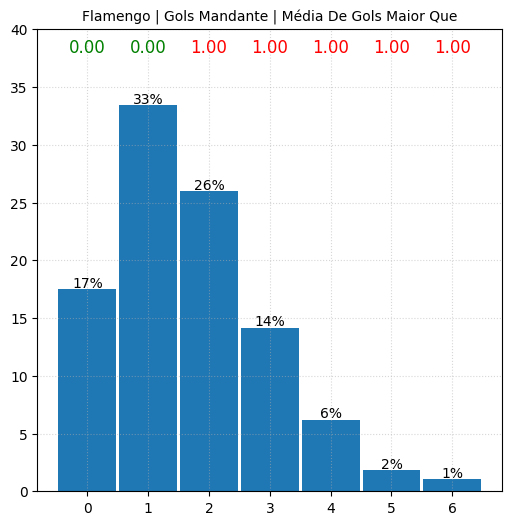

In [174]:
# plot pdf
max_y = 40.0
fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
_ = ax.set_title(f"{time_A.capitalize()} | Gols Mandante | Média De Gols Maior Que", fontsize=10)
_ = ax.bar(pdf_A_mandante_gols.index, 100.0*pdf_A_mandante_gols.proportion.values, tick_label=pdf_A_mandante_gols.index, width=0.95)
_ = ax.set_ylim([0, max_y])
_ = ax.grid(ls=':', alpha=0.5)
for gol_amount, p_gol in pdf_A_mandante_gols.iterrows():
    _ = ax.annotate(f'{100.0*p_gol.proportion:.0f}%', xy=(gol_amount, 100.0*p_gol.proportion), xytext=(gol_amount, 100.0*p_gol.proportion+0.2), ha='center', fontsize=10)
    # z test each gol amount for larger
    z_stat, p_value_gol_amount = statsmodels_stats.weightstats.ztest(df_A_mandante_gols.values, value=gol_amount, alternative='larger')
    # annotate p_value
    if p_value_gol_amount <= a_significancia:
        anot_color = 'green'
    else:
        anot_color = 'red'
    _ = ax.annotate(f'{p_value_gol_amount:.2f}', xy=(gol_amount, 100.0*p_gol.proportion), xytext=(gol_amount, max_y - 2), ha='center', fontsize=12, color=anot_color)

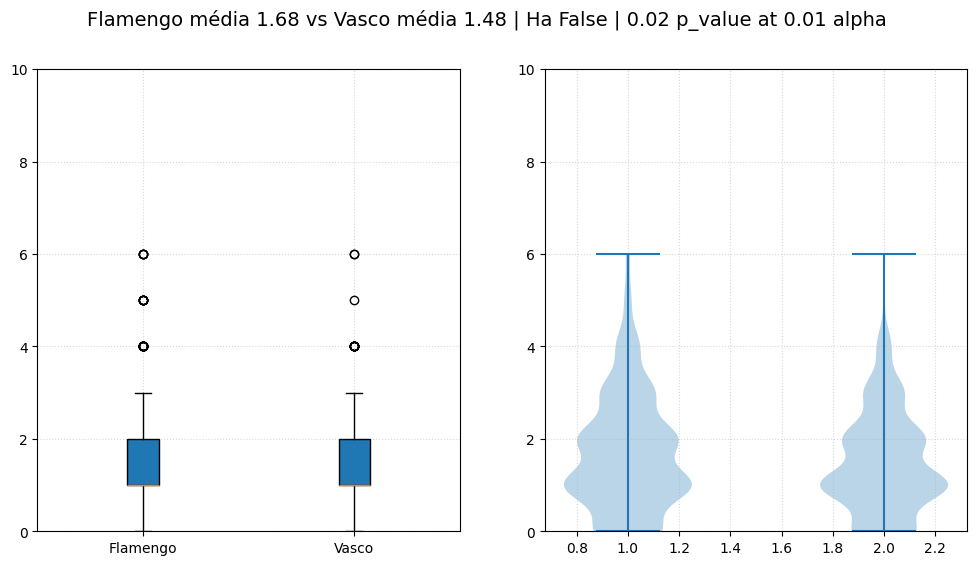

In [175]:
# BOXPLOT pdf A mandante VS pdf B mandante
t_stat, t_p_value, n_freedom = statsmodels_stats.weightstats.ttest_ind(df_A_mandante_gols.values, df_B_mandante_gols.values, alternative='larger')
this_Ha = t_p_value <= a_significancia

fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
_ = fig.suptitle(f"{time_A.capitalize()} média {df_A_mandante_gols.mean():.2f} vs {time_B.capitalize()} média {df_B_mandante_gols.mean():.2f} | Ha {this_Ha} | {t_p_value:.2f} p_value at {a_significancia} alpha", fontsize=14)
_ = ax.boxplot([df_A_mandante_gols.values, df_B_mandante_gols.values], labels=[time_A.capitalize(), time_B.capitalize()], patch_artist=True)
_ = ax.set_ylim([0, 10])
_ = ax.grid(ls=':', alpha=0.5)
ax2 = fig.add_subplot(122)
_ = ax2.violinplot([df_A_mandante_gols.values, df_B_mandante_gols.values], )
_ = ax2.set_ylim([0, 10])
_ = ax2.grid(ls=':', alpha=0.5)


In [176]:
statsmodels_stats.weightstats.ttest_ind(df_A_mandante_gols.values, df_B_mandante_gols.values, alternative='larger')

(2.0556406638468667, 0.020098670262256035, 682.0)

In [177]:
# IMPORTAR GOLS
df_stats_path = os.path.join(datasets_folder,'brasileirao', 'campeonato-brasileiro-estatisticas-full.csv')
df_stats = pandas.read_csv(df_stats_path, sep=',', decimal='.')
df_stats["clube"] = df_stats["clube"].str.strip().str.lower()
df_stats['cartoes'] = df_stats['cartao_amarelo'] + df_stats['cartao_vermelho']
df_stats['time'] = 'outros'
df_stats.loc[df_stats.clube == time_A, 'time'] = time_A
df_stats = df_stats[['chutes', 'chutes_no_alvo', 'impedimentos', 'escanteios', 'time']]

df_stats.head()

,chutes,chutes_no_alvo,impedimentos,escanteios,time
0,0,0,0,0,outros
1,0,0,0,0,outros
2,0,0,0,0,outros
3,0,0,0,0,outros
4,0,0,0,0,flamengo


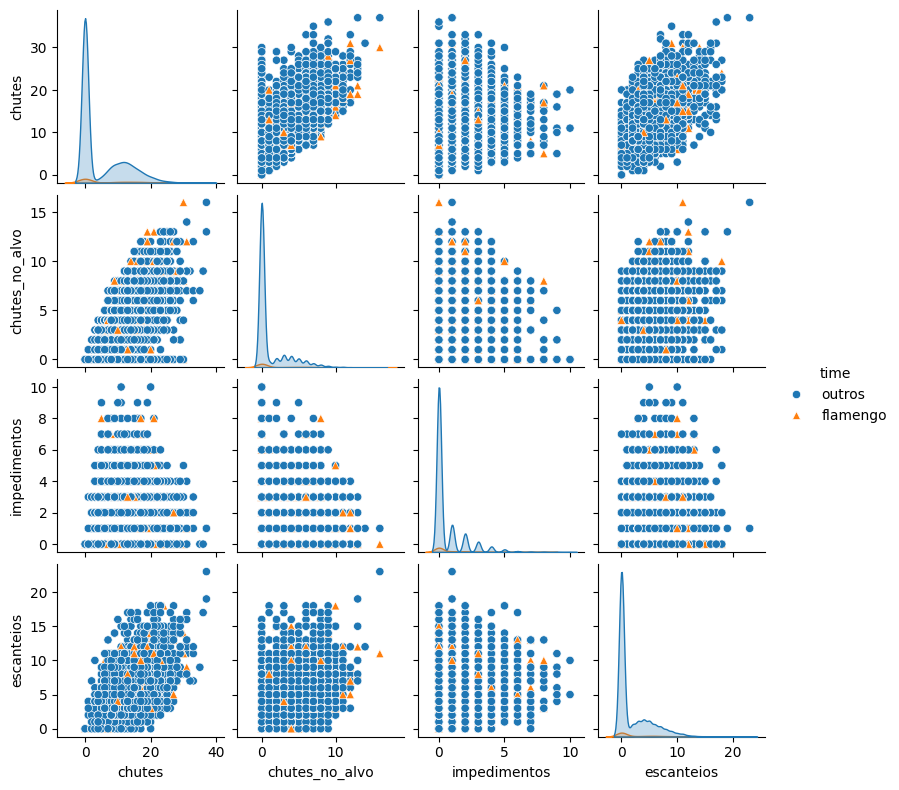

In [166]:
import seaborn
_ = seaborn.pairplot(df_stats, hue='time', markers=["o", "^"], height=2)

<Axes: >

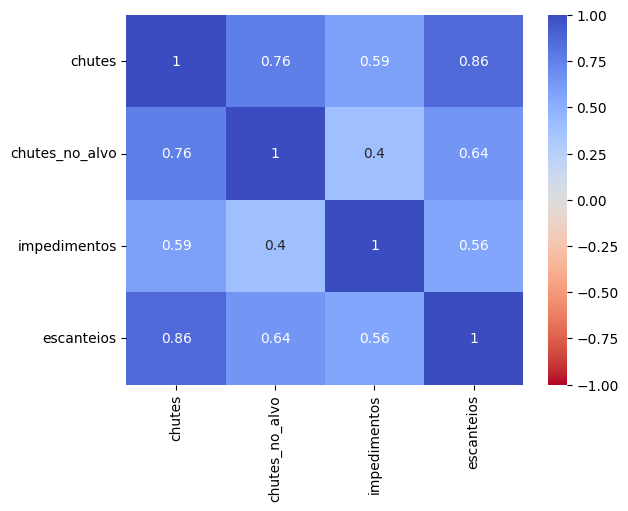

In [167]:
seaborn.heatmap(df_stats.iloc[:, :-1].corr(), annot=True, cmap='coolwarm_r', vmax=1.0, vmin=-1.0)